This project analysis a time series on frozen dessert production and creates a forecast model using LSTM.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load the data
df=pd.read_csv('/content/drive/MyDrive/FINAL_TF2_FILES/TF_2_Notebooks_and_Data/DATA/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)

In [ ]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [ ]:
df.columns = ['Production']

In [ ]:
df.tail()

,Production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [ ]:
# 573 rows
 
df.shape

(573, 1)

# EDA

In [ ]:
# Interactive Time Series plot of Production
 
fig = px.line(df, y='Production', x=df.index, title='Production Time Series')
fig.update_layout(xaxis_title='Date')
fig.show()

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
DecompDataAdd = seasonal_decompose(df, model='additive', freq=1)

In [ ]:
DecompDataAdd.plot()

In [ ]:
# Use the content of DecompDataAdd to remove the effect of seasonality from the time series
SeasRemov= df-DecompDataAdd.seasonal

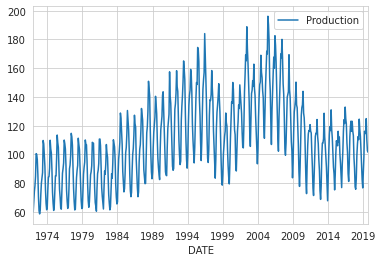

In [ ]:
# Seasonality had been removed
# an increasing trend from '84-'07 is apparent
SeasRemov.plot()
plt.show()

### EDA with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [ ]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig)
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
public_url

<NgrokTunnel: "http://7ac82d05d975.ngrok.io" -> "http://localhost:8050">

In [ ]:
ngrok.kill()

# RNN Model

## Train-test Split

In [ ]:
len(df)

573

In [ ]:
test_size = 24

In [ ]:
test_ind = len(df)- test_size # test index

In [ ]:
train = df.iloc[:test_ind] # training set
test = df.iloc[test_ind:] # testing set is last 24 values

## Scale Data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Time Series Generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
length = 24
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Create the Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [ ]:
n_features = 1

In [ ]:
model = Sequential()
model.add(LSTM(115, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 115)               53820     
_________________________________________________________________
dense (Dense)                (None, 1)                 116       
Total params: 53,936
Trainable params: 53,936
Non-trainable params: 0
_________________________________________________________________


In [ ]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=20, batch_size=1)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
model.fit_generator(generator,epochs=25,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/25
525/525 [==============================] - 8s 12ms/step - loss: 0.0286 - val_loss: 0.0071
Epoch 2/25
525/525 [==============================] - 6s 12ms/step - loss: 0.0100 - val_loss: 0.0016
Epoch 3/25
525/525 [==============================] - 6s 12ms/step - loss: 0.0048 - val_loss: 0.0026
Epoch 4/25
525/525 [==============================] - 6s 12ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 5/25
525/525 [==============================] - 6s 12ms/step - loss: 0.0036 - val_loss: 0.0031


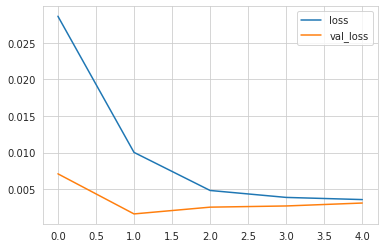

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

In [ ]:
test_predictions = []
 
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,88.897637
2017-11-01,77.4378,82.364085
2017-12-01,75.8118,81.923146
2018-01-01,83.4343,87.747738
2018-02-01,99.4899,96.377688
2018-03-01,107.3152,105.185091
2018-04-01,112.4309,112.327320
2018-05-01,110.3544,116.799694
2018-06-01,124.5841,118.062897


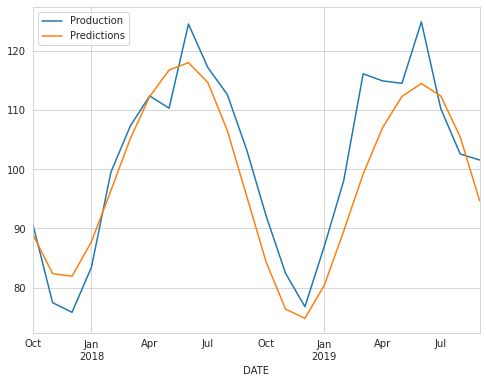

In [ ]:
test.plot(figsize=(8,6))

In [ ]:
from sklearn import metrics

In [ ]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(test['Production'], test['Predictions'])))

RMSE: 6.546009525218934


# Forecast

In [ ]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [ ]:
length = 24 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(115, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
 
 
# fit model
model.fit_generator(generator,epochs=8)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/8
549/549 [==============================] - 8s 11ms/step - loss: 0.0243
Epoch 2/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0085
Epoch 3/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0046
Epoch 4/8
549/549 [==============================] - 6s 12ms/step - loss: 0.0037
Epoch 5/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0032
Epoch 6/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0034
Epoch 7/8
549/549 [==============================] - 6s 12ms/step - loss: 0.0029
Epoch 8/8
549/549 [==============================] - 6s 11ms/step - loss: 0.0029


In [ ]:
forecast = []
# Replace periods with forecast length
periods = 12
 
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start='2019-10-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-10-01,89.830868
2019-11-01,83.144803
2019-12-01,82.327609
2020-01-01,89.582255
2020-02-01,99.475629
2020-03-01,107.983910
2020-04-01,114.378744
2020-05-01,119.336443
2020-06-01,120.313524
2020-07-01,115.753472


In [ ]:
Forecast = pd.concat([df, forecast_df])

In [ ]:
Forecast.head()

,Production,Forecast
1972-01-01,59.9622,NaN
1972-02-01,67.0605,NaN
1972-03-01,74.2350,NaN
1972-04-01,78.1120,NaN
1972-05-01,84.7636,NaN


In [ ]:
Forecast.tail()

,Production,Forecast
2020-05-01,NaN,119.336443
2020-06-01,NaN,120.313524
2020-07-01,NaN,115.753472
2020-08-01,NaN,106.175101
2020-09-01,NaN,95.579413


In [ ]:
# Plot of previous and forecasted data

import plotly.graph_objects as go

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Production'],
                    mode='lines',
                    name='Production'))
fig2.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Forecast'],
                    mode='lines',
                    name='Forecast'))

In [ ]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig2)
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
public_url

<NgrokTunnel: "http://eb2bfab75b8d.ngrok.io" -> "http://localhost:8050">

In [ ]:
ngrok.kill()

# Save model and scaler

In [ ]:
from google.colab import drive
 
drive.mount('drive')

In [ ]:
from tensorflow.keras.models import load_model
import joblib

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_model.h5')

In [ ]:
# Save the scaler
joblib.dump(scaled_full_data, '/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_scaler.pkl')

['/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_scaler.pkl']

# Load and run the model

In [ ]:
from google.colab import drive
 
drive.mount('drive')

import pandas as pd
import numpy as np

Mounted at drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/FINAL_TF2_FILES/TF_2_Notebooks_and_Data/DATA/Frozen_Dessert_Production.csv',index_col='DATE',parse_dates=True)
df.columns = ['Production']

In [ ]:
from tensorflow.keras.models import load_model
import joblib

In [ ]:
FC_model = load_model('/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_model.h5')

In [ ]:
FC_scaler = joblib.load("/content/drive/MyDrive/Projects/ForecastingProduction_RNN/FC_scaler.pkl")

In [ ]:
forecast = []
# Replace periods with forecast length
periods = 12
length = 24
n_features = 1
 
first_eval_batch = FC_scaler[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
 
for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = FC_model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_index = pd.date_range(start='2019-10-01',periods=periods,freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-10-01,89.830868
2019-11-01,83.144803
2019-12-01,82.327609
2020-01-01,89.582255
2020-02-01,99.475629
2020-03-01,107.983910
2020-04-01,114.378744
2020-05-01,119.336443
2020-06-01,120.313524
2020-07-01,115.753472


In [ ]:
Forecast = pd.concat([df, forecast_df])
Forecast

,Production,Forecast
1972-01-01,59.9622,NaN
1972-02-01,67.0605,NaN
1972-03-01,74.2350,NaN
1972-04-01,78.1120,NaN
1972-05-01,84.7636,NaN
...,...,...
2020-05-01,NaN,119.336443
2020-06-01,NaN,120.313524
2020-07-01,NaN,115.753472
2020-08-01,NaN,106.175101


## Deploy the forecast with Dash and ngrok

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [ ]:
# Plot of previous and forecasted data

import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Production'],
                    mode='lines',
                    name='Production'))
fig.add_trace(go.Scatter(x=Forecast.index, y=Forecast['Forecast'],
                    mode='lines',
                    name='Forecast'))

In [ ]:
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig)
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
public_url

<NgrokTunnel: "http://1ccb098ef8a5.ngrok.io" -> "http://localhost:8050">

In [ ]:
ngrok.kill()